In [1]:
!pip install transformers
!pip install tweet-preprocessor
!pip install SentencePiece

In [9]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import preprocessor as p
import string

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI, p.OPT.HASHTAG)


def remove_characters(str_, chars):
    
    for char in chars:
        str_ = str_.replace(char, '')
        
    return str_


def preprocessing(data):

    data['text'] = data['text'].apply(lambda text: text.lower())
    data['text'] = data['text'].apply(lambda tweet: p.clean(tweet))
    data['text'] = data['text'].apply(lambda tweet: remove_characters(tweet, string.punctuation))

    return data


def generate_x_y(data, max_len=128):

    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

    x, mask, y = [], [], []
    for i, row in data.iterrows():

        sample = row['text']
        label = row['label']
        tokens = ['[CLS]'] + tokenizer.tokenize(sample) + ['[SEP]']

        if len(tokens) < max_len:
            tokens = ['[PAD]' for _ in range(max_len - len(tokens))] + tokens 
        else:
            tokens = ['[CLS]'] + tokens[-max_len+1:]

        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        sample_mask = [1 if token != '[PAD]' else 0 for token in tokens]

        x.append(token_ids)
        mask.append(sample_mask)
        y.append(label)

    return torch.tensor(x), torch.tensor(mask), torch.tensor(y)


data = pd.read_csv('/content/drive/MyDrive/HateEval/train.csv')
data = preprocessing(data)
x_train, mask_train, y_train = generate_x_y(data)

data = pd.read_csv('/content/drive/MyDrive/HateEval/test.csv')
data = preprocessing(data)
x_test, mask_test, y_test = generate_x_y(data)

In [5]:
class TweetClassifier(nn.Module):

    def __init__(self):

        super(TweetClassifier, self).__init__()

        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        for p in self.xlnet.parameters():
            p.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 2),
            nn.Softmax()
        )

    def forward(self, seq, mask):

        outputs = self.xlnet(input_ids=seq, attention_mask=mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        out = self.classifier(last_hidden_state_cls)

        return out

In [6]:
train_data = TensorDataset(x_train, mask_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

test_data = TensorDataset(x_test, mask_test, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

model = TweetClassifier().cuda()

loss = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=2e-4)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def train(model, loss_func, opt, train_loader, test_loader, epochs=10):

    model.train()
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for i, batch in enumerate(train_loader):
            
            model.zero_grad()
            seq, padd_mask, labels = tuple(d.cuda() for d in batch)

            out = model(seq, padd_mask)
            loss = loss_func(out, labels)
            train_losses.append(loss)
            loss.backward()
            opt.step()

            with torch.no_grad():

                if (i + 1) % 100 == 0:
                
                    test_loss = 0
                    for b in test_loader:
                        test_seq, test_mask, test_label = tuple(d.cuda() for d in b)
                        pred = model(test_seq, test_mask)
                        test_loss += loss_func(pred, test_label)
                    test_losses.append(test_loss)
                    
                    labels, out = labels.cpu(), out.cpu()
                    out = [np.argmax(pred) for pred in out]
                    acc = accuracy_score(labels, out)
                    print("Iteration {} of epoch {} complete. Loss: {}, Accuracy: {}".format(i+1, epoch+1, loss.item(), acc))

    return model, train_losses, test_losses

In [8]:
model, train_losses, test_losses = train(model, loss, opt, train_dataloader, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 100 of epoch 1 complete. Loss: 0.6103927493095398, Accuracy: 0.6875
Iteration 200 of epoch 1 complete. Loss: 0.6222758889198303, Accuracy: 0.65625
Iteration 300 of epoch 1 complete. Loss: 0.5700212121009827, Accuracy: 0.71875
Iteration 100 of epoch 2 complete. Loss: 0.5974933505058289, Accuracy: 0.625
Iteration 200 of epoch 2 complete. Loss: 0.6043529510498047, Accuracy: 0.6875
Iteration 300 of epoch 2 complete. Loss: 0.6889690160751343, Accuracy: 0.625
Iteration 100 of epoch 3 complete. Loss: 0.6885930299758911, Accuracy: 0.5625
Iteration 200 of epoch 3 complete. Loss: 0.5863471627235413, Accuracy: 0.6875
Iteration 300 of epoch 3 complete. Loss: 0.7218068242073059, Accuracy: 0.5
Iteration 100 of epoch 4 complete. Loss: 0.6005690693855286, Accuracy: 0.71875
Iteration 200 of epoch 4 complete. Loss: 0.6915431022644043, Accuracy: 0.59375
Iteration 300 of epoch 4 complete. Loss: 0.5906431078910828, Accuracy: 0.71875
Iteration 100 of epoch 5 complete. Loss: 0.5273256301879883, Acc

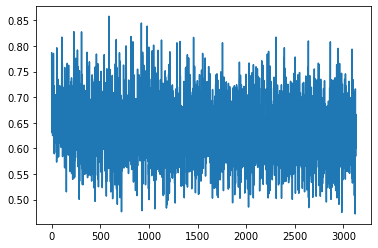

In [15]:
plt.plot(range(len(train_losses)), train_losses)
plt.show()

In [14]:
with torch.no_grad():

    y_true, y_pred = [], []
    for batch in test_dataloader:
        test_seq, test_mask, test_label = tuple(d.cuda() for d in batch)
        pred = model(test_seq, test_mask)
        test_label, pred = test_label.cpu().numpy().tolist(), pred.cpu().numpy().tolist()
        pred = [np.argmax(p) for p in pred]

        y_true = y_true + test_label
        y_pred = y_pred + pred

    print(classification_report(y_true, y_pred))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1740
           1       0.50      0.61      0.55      1260

    accuracy                           0.58      3000
   macro avg       0.58      0.58      0.58      3000
weighted avg       0.59      0.58      0.58      3000



In [16]:
model, train_losses, test_losses = train(model, loss, opt, train_dataloader, test_dataloader, epochs=7)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 100 of epoch 1 complete. Loss: 0.6522521376609802, Accuracy: 0.625
Iteration 200 of epoch 1 complete. Loss: 0.6784695386886597, Accuracy: 0.59375
Iteration 300 of epoch 1 complete. Loss: 0.5497523546218872, Accuracy: 0.75
Iteration 100 of epoch 2 complete. Loss: 0.5923814177513123, Accuracy: 0.75
Iteration 200 of epoch 2 complete. Loss: 0.6749507188796997, Accuracy: 0.59375
Iteration 300 of epoch 2 complete. Loss: 0.5447482466697693, Accuracy: 0.8125
Iteration 100 of epoch 3 complete. Loss: 0.6506744623184204, Accuracy: 0.625
Iteration 200 of epoch 3 complete. Loss: 0.6888316869735718, Accuracy: 0.625
Iteration 300 of epoch 3 complete. Loss: 0.6200543642044067, Accuracy: 0.59375
Iteration 100 of epoch 4 complete. Loss: 0.620608925819397, Accuracy: 0.6875
Iteration 200 of epoch 4 complete. Loss: 0.5694777369499207, Accuracy: 0.75
Iteration 300 of epoch 4 complete. Loss: 0.6637851595878601, Accuracy: 0.5625
Iteration 100 of epoch 5 complete. Loss: 0.7173181176185608, Accuracy: 

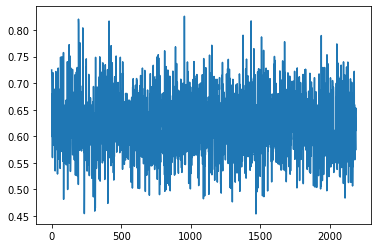

In [17]:
plt.plot(range(len(train_losses)), train_losses)
plt.show()

In [18]:
with torch.no_grad():

    y_true, y_pred = [], []
    for batch in test_dataloader:
        test_seq, test_mask, test_label = tuple(d.cuda() for d in batch)
        pred = model(test_seq, test_mask)
        test_label, pred = test_label.cpu().numpy().tolist(), pred.cpu().numpy().tolist()
        pred = [np.argmax(p) for p in pred]

        y_true = y_true + test_label
        y_pred = y_pred + pred

    print(classification_report(y_true, y_pred))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.67      0.59      0.63      1740
           1       0.51      0.59      0.55      1260

    accuracy                           0.59      3000
   macro avg       0.59      0.59      0.59      3000
weighted avg       0.60      0.59      0.60      3000



In [19]:
model, train_losses, test_losses = train(model, loss, opt, train_dataloader, test_dataloader, epochs=4)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 100 of epoch 1 complete. Loss: 0.6534723043441772, Accuracy: 0.625
Iteration 200 of epoch 1 complete. Loss: 0.6346195936203003, Accuracy: 0.6875
Iteration 300 of epoch 1 complete. Loss: 0.6017452478408813, Accuracy: 0.75
Iteration 100 of epoch 2 complete. Loss: 0.5424251556396484, Accuracy: 0.78125
Iteration 200 of epoch 2 complete. Loss: 0.6619033217430115, Accuracy: 0.65625
Iteration 300 of epoch 2 complete. Loss: 0.6719434261322021, Accuracy: 0.625
Iteration 100 of epoch 3 complete. Loss: 0.6457557082176208, Accuracy: 0.6875
Iteration 200 of epoch 3 complete. Loss: 0.6489772796630859, Accuracy: 0.625
Iteration 300 of epoch 3 complete. Loss: 0.6733413934707642, Accuracy: 0.53125
Iteration 100 of epoch 4 complete. Loss: 0.677311360836029, Accuracy: 0.625
Iteration 200 of epoch 4 complete. Loss: 0.6764035224914551, Accuracy: 0.65625
Iteration 300 of epoch 4 complete. Loss: 0.5216038823127747, Accuracy: 0.84375


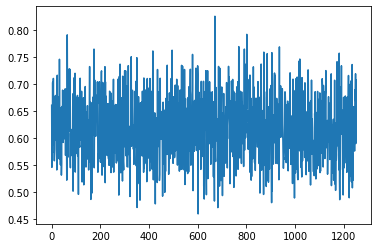

In [20]:
plt.plot(range(len(train_losses)), train_losses)
plt.show()

In [21]:
with torch.no_grad():

    y_true, y_pred = [], []
    for batch in test_dataloader:
        test_seq, test_mask, test_label = tuple(d.cuda() for d in batch)
        pred = model(test_seq, test_mask)
        test_label, pred = test_label.cpu().numpy().tolist(), pred.cpu().numpy().tolist()
        pred = [np.argmax(p) for p in pred]

        y_true = y_true + test_label
        y_pred = y_pred + pred

    print(classification_report(y_true, y_pred))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.67      0.54      0.59      1740
           1       0.50      0.63      0.56      1260

    accuracy                           0.58      3000
   macro avg       0.58      0.58      0.58      3000
weighted avg       0.60      0.58      0.58      3000

